# 1. Setup

In [1]:
import sys
sys.path.append('../..')
import mobiquity as mq
from mobiquity.names import *

import plotly.express as px
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# 2. Prepare data

## 2.1. Load data

In [2]:
trips = U.load(DATA / 'access/impedance/trips.parquet').disp()

747,088 rows x 21 cols; Memory: 34.9 MiB


,Distance,Time,Speed,Weight,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,...,Region,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn
,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,1.0,HBO,Drive,No,Low,Long,Off-peak,...,South,Senior,Female,Non-White,No,College,No,Mid,Own,High


In [3]:
factors = list(trips.select_dtypes(CAT).columns)

In [4]:
col_groups = []
for grp, start, end, color in [
        ('Trip', 'Purpose', 'Urbanity', 'deepskyblue'),
        ('Traveler', 'Region', 'VehOwn', 'hotpink')]:
    df = Pdf(D(factor=trips.loc[:, start: end].columns))
    col_groups.append(df.assign(group=grp, color=color))
col_groups = pd.concat(col_groups).reset_index(drop=1).disp()

17 rows x 3 cols; Memory: 0.0 MiB


,factor,group,color
,<object>,<object>,<object>
0,Purpose,Trip,deepskyblue


In [5]:
levels = Pdf(sum([[(col, x, i+1) for i, x in enumerate(trips[col].cat.categories)]
                  for col in trips.select_dtypes(CAT)], []),
             columns=['factor', 'level', 'level_num']).disp()

52 rows x 3 cols; Memory: 0.0 MiB


,factor,level,level_num
,<object>,<object>,<int64>
0,Purpose,HBW,1


# 3. Distributions

## 3.1. Interactive distributions

In [6]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for trg, vmin, vmax in [('Time', 0, 90), ('Distance', 0, 100), ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                vals = df[trg].clip(vmin, vmax)
                y, x = np.histogram(vals, bins=100, weights=df.Weight)
                y = (y / y.sum()).cumsum()
                df = Pdf(D(value=x[1:], density=y))
                res.append(df.assign(var=var, cat=cat, target=trg))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='target',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

# plot_distr_vars() # 5s

## 3.2. Variable-wise histogram

In [7]:
def get_var_hist(data=trips, max_vals=D(Distance=100, Time=120)):
    res = []
    for col in data.select_dtypes(CAT).columns:
        for var, df in data.groupby(col):
            for target, vmax in max_vals.items():
                y = df[target].clip(0, vmax)
                y, x = np.histogram(y, bins=np.arange(0, vmax + 1))
                y = (1 - (y / y.sum()).cumsum()).clip(0)
                res.append(D(target=target, factor=col,
                             level=var, x=x[1:], y=y))
    return Pdf(res)

var_hist = get_var_hist().disp() # 2s

104 rows x 5 cols; Memory: 0.1 MiB


,target,factor,level,x,y
,<object>,<object>,<object>,<object>,<object>
0,Distance,Purpose,HBW,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9612716872850274, 0.9134028846702013, 0.863..."


# 4. Decay rate parameter

## 4.1. Select functional form

In [9]:
imped_funcs = {
    'Power':                 lambda x, a: x ** a,
    'Base exponential':      lambda x, a: np.exp(a * x),
    'Sherratt Tanner':       lambda x, a: np.exp(-a * (x ** 2)),
    'Logistic':              lambda x, a: 2 * (1 + np.exp(a * x)) ** (-1),
    'Power exponential':     lambda x, a, b: np.exp(-a * (x ** b)),
    'Tanner':                lambda x, a, b: (x ** a) * np.exp(b * x),
    'Quadratic exponential': lambda x, a, b: np.exp(a * x - b * (x ** 2)),
    # 'Cubic exponential':     lambda x, a, b, c: np.exp(-a * x + b * (x ** 2) - c * (x ** 3)),
}

In [10]:
def fit_decay_functions(funcs=imped_funcs, hists=var_hist):
    res = []
    for _, r in hists.iterrows():
        for fname, func in funcs.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, r.x, r.y)[0]
                yfit = func(r.x, *params).clip(0, 1)
                r2 = r2_score(r.y, yfit)
                if r2 < 0 or r2 > 1: continue
            except RuntimeError as e:
                print('ERROR:', fname, r, e)
                continue
            res.append(D(target=r.target, factor=r.factor, 
                         level=r.level, func=fname,
                         r2=r2, params=list(params)))
    res = Pdf(res)
    return res

fitted = fit_decay_functions().disp()

727 rows x 6 cols; Memory: 0.2 MiB


,target,factor,level,func,r2,params
,<object>,<object>,<object>,<object>,<float64>,<object>
0,Distance,Purpose,HBW,Power,0.707913,[-0.4892477188849867]


### 4.1.1. Fitness scores

In [11]:
(fitted.groupby(['func', 'target'])['r2'].describe()
 .reset_index().melt(['func', 'target'])
 .assign(statistic=lambda df: pd.Categorical(
     df.variable, categories=['mean', 'std', 'min', 'max']))
 .pivot_table('value', 'func', ['target', 'statistic'])
 .loc[list(imped_funcs.keys())].reset_index())

target                      func  Distance                                \
statistic                             mean       std       min       max   
0                          Power  0.843897  0.058662  0.612593  0.939323   
1               Base exponential  0.973893  0.011054  0.947491  0.999716   
2                Sherratt Tanner  0.790617  0.051276  0.709990  0.949013   
3                       Logistic  0.938804  0.022698  0.898645  0.996552   
4              Power exponential  0.997034  0.002333  0.987333  0.999830   
5                         Tanner  0.996027  0.003893  0.973517  0.999789   
6          Quadratic exponential  0.988310  0.007040  0.962058  0.999937   

target         Time                                
statistic      mean       std       min       max  
0          0.648618  0.039521  0.476779  0.726955  
1          0.979040  0.011420  0.927372  0.997833  
2          0.965636  0.012718  0.903767  0.991164  
3          0.991289  0.005331  0.966542  0.995715  
4          0.995530  0.001185  0.992032  0.998709  
5          0.997329  0.000980  0.993238  0.998980  
6          0.992001  0.001801  0.987652  0.997928

## 4.2. Fit curves

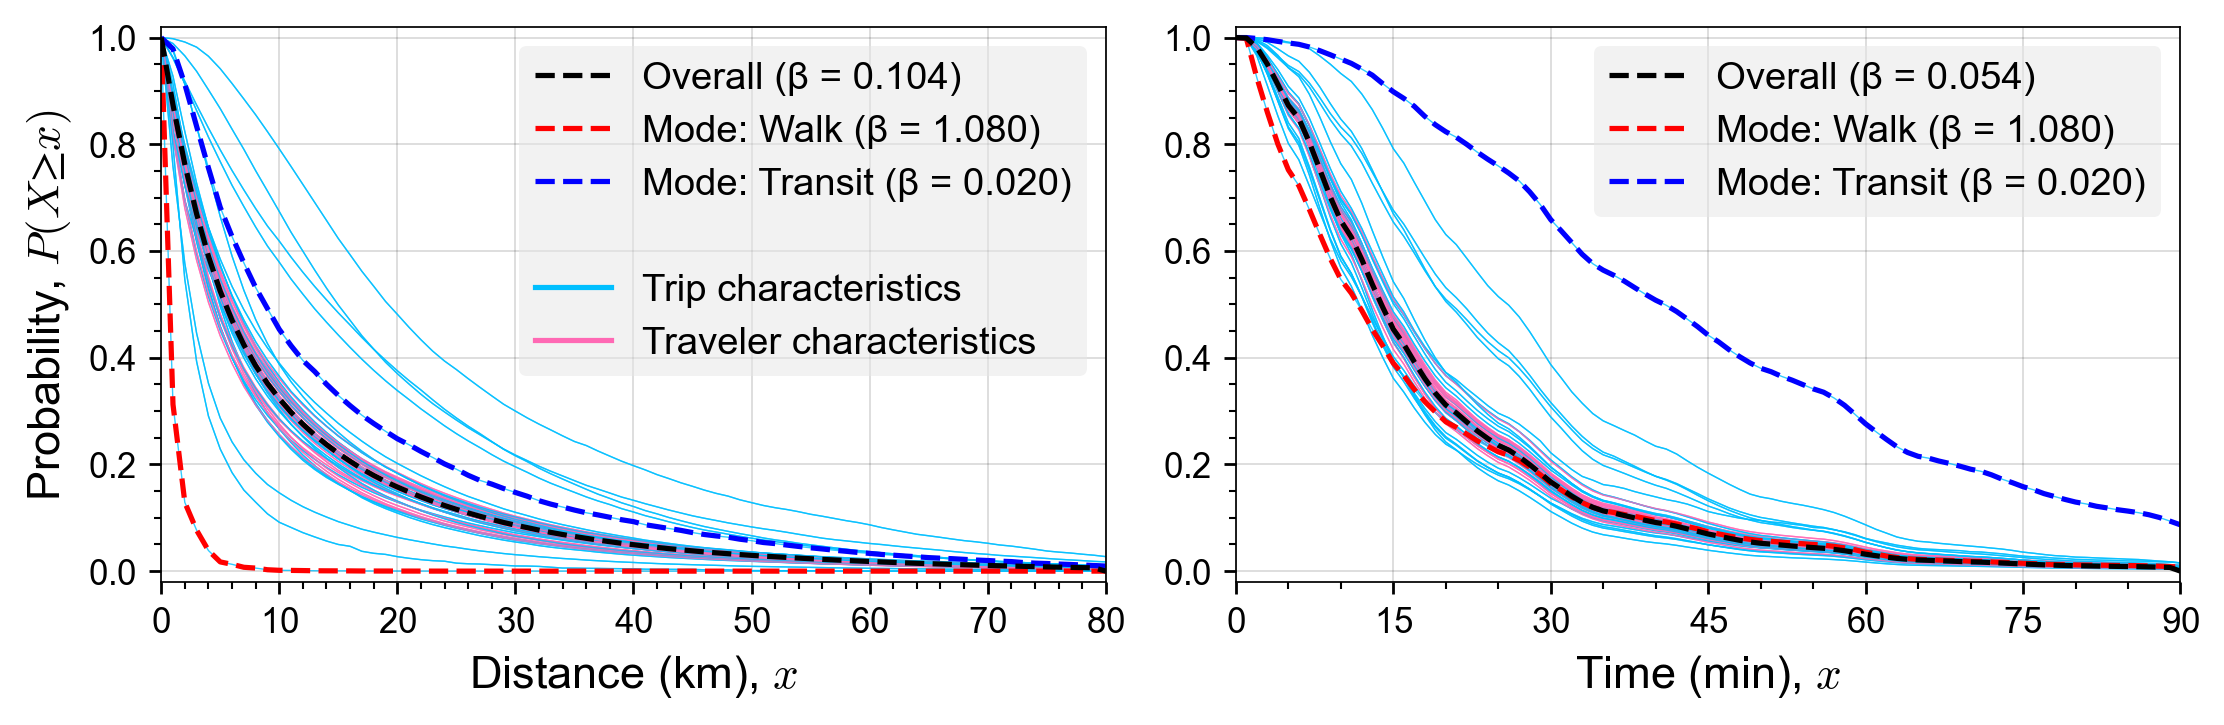

In [12]:
def fig_fitted_curves(fitted=fitted, hists=var_hist, groups=col_groups,
                      adv=True, trips=trips, size=(9, 3), dpi=150):
    fit = (U.filt(fitted, func='Base exponential')
           .explode('params').rename(columns=D(params='beta'))
           .merge(groups[['factor', 'color']]))
    if not adv: fit.color = fit.color.iloc[0]
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for j, target, vmax, xlab in [(0, 'Distance', 80, 'Distance (km)'),
                                  (1, 'Time', 90, 'Time (min)')]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        lgd = [line('Overall' + (f' (β = {beta:.3f})' if adv else ''), color='k', ls='--')]
        ax = U.plot(axes[j], xlim=(0, vmax), ylim=(-0.02, 1.02), xlab=f'{xlab}, $x$',
                    ylab='Probability, $P(X≥x)$' if j == 0 else '')
        df = U.filt(hists, target=target)
        df = df.merge(fit[['target', 'factor', 'level', 'beta', 'color']])
        df = df.sort_values('beta').reset_index(drop=1)
        for _, r in df.iloc[1:-1].iterrows():
            ax.plot([0] + list(r.x), [1] + list(r.y), color=r.color, lw=0.4, alpha=0.8)
        for r, color in zip([df.iloc[0], df.iloc[-1]], ['r', 'b']):
            label = f'{r.factor}: {r.level}' + (f' (β = {-r.beta:.3f})' if adv else '')
            lgd += [line(label, color=color, ls='--')]
            ax.plot([0] + list(r.x), [1] + list(r.y), color=color, lw=1.5, ls='--')
        ax.plot(X, [1] + list(Y), '--k', lw=1.5)
        if target == 'Time':
            ax.set_xticks(np.arange(0, 91, 15))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0 and adv:
            lgd += [line('', color='none')]
            for _, r in groups.drop_duplicates(subset=['group']).iterrows():
                lgd += [line(r.group + ' characteristics', color=r.color)]
        ax.legend(handles=lgd)
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    U.imsave(f'Impedance curves by variable' + (' (no label)' if adv else ''))

fig_fitted_curves(dpi=250)

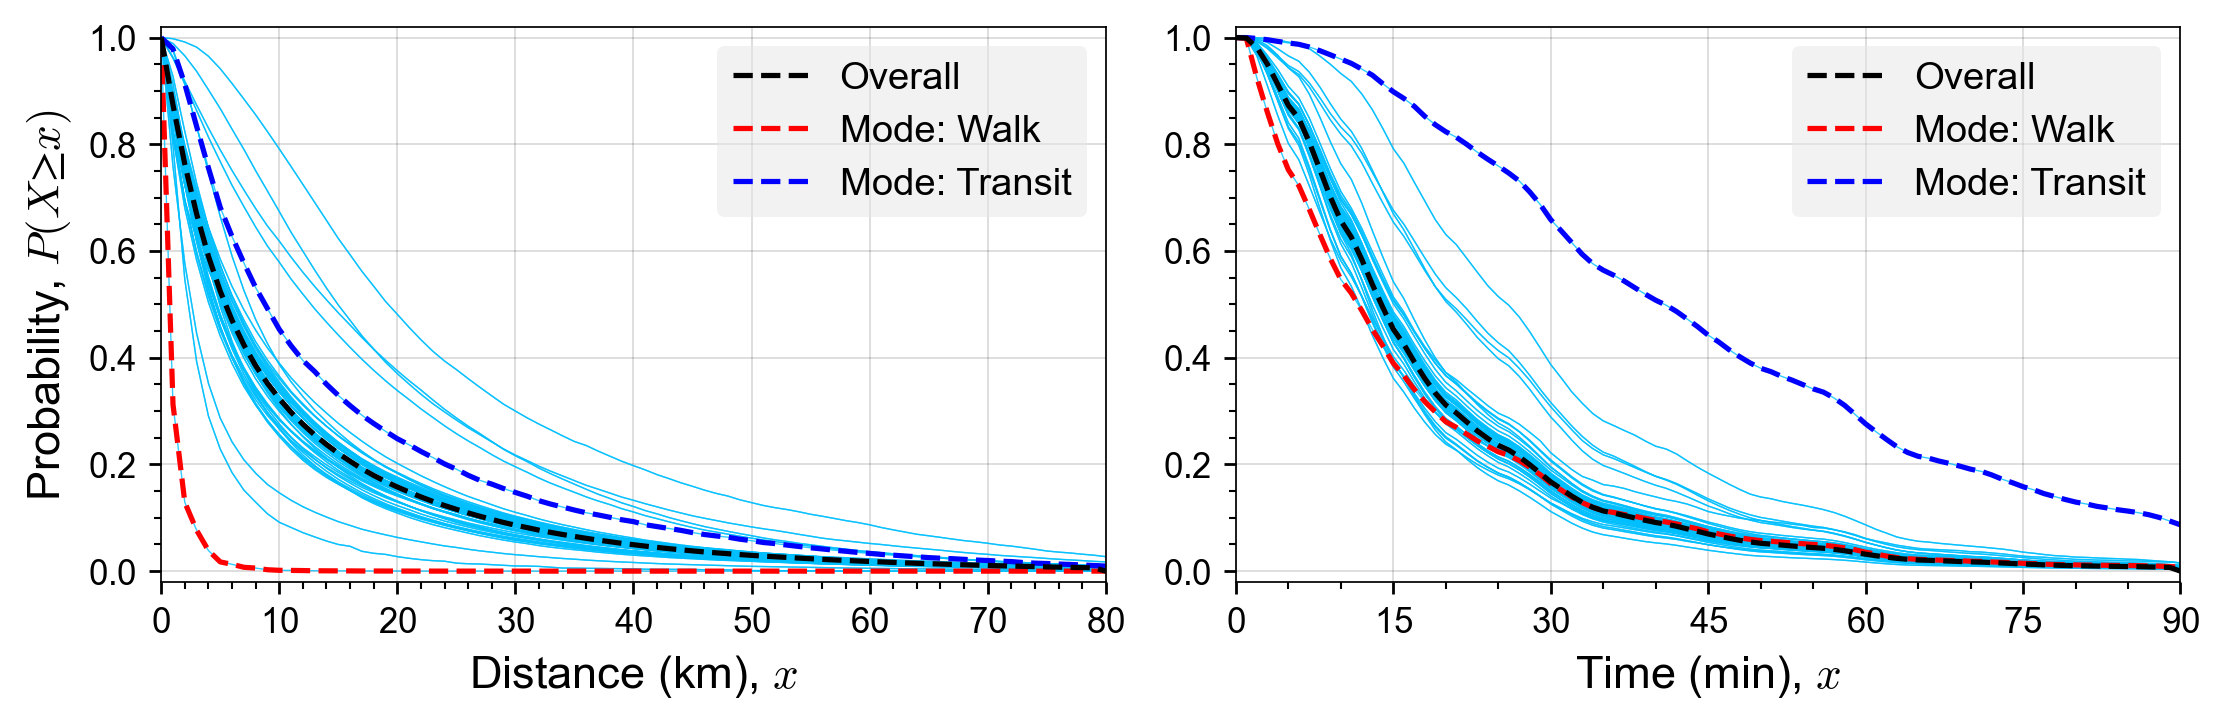

In [13]:
fig_fitted_curves(adv=False, dpi=250)

## 4.3. Compare beta parameters

208 rows x 8 cols; Memory: 0.3 MiB


,factor,level,x,y,group,color,target,beta
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Mode,Walk,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.31236868338317614, 0.12887048539222457, 0.0...",Trip,deepskyblue,Distance,-1.079607


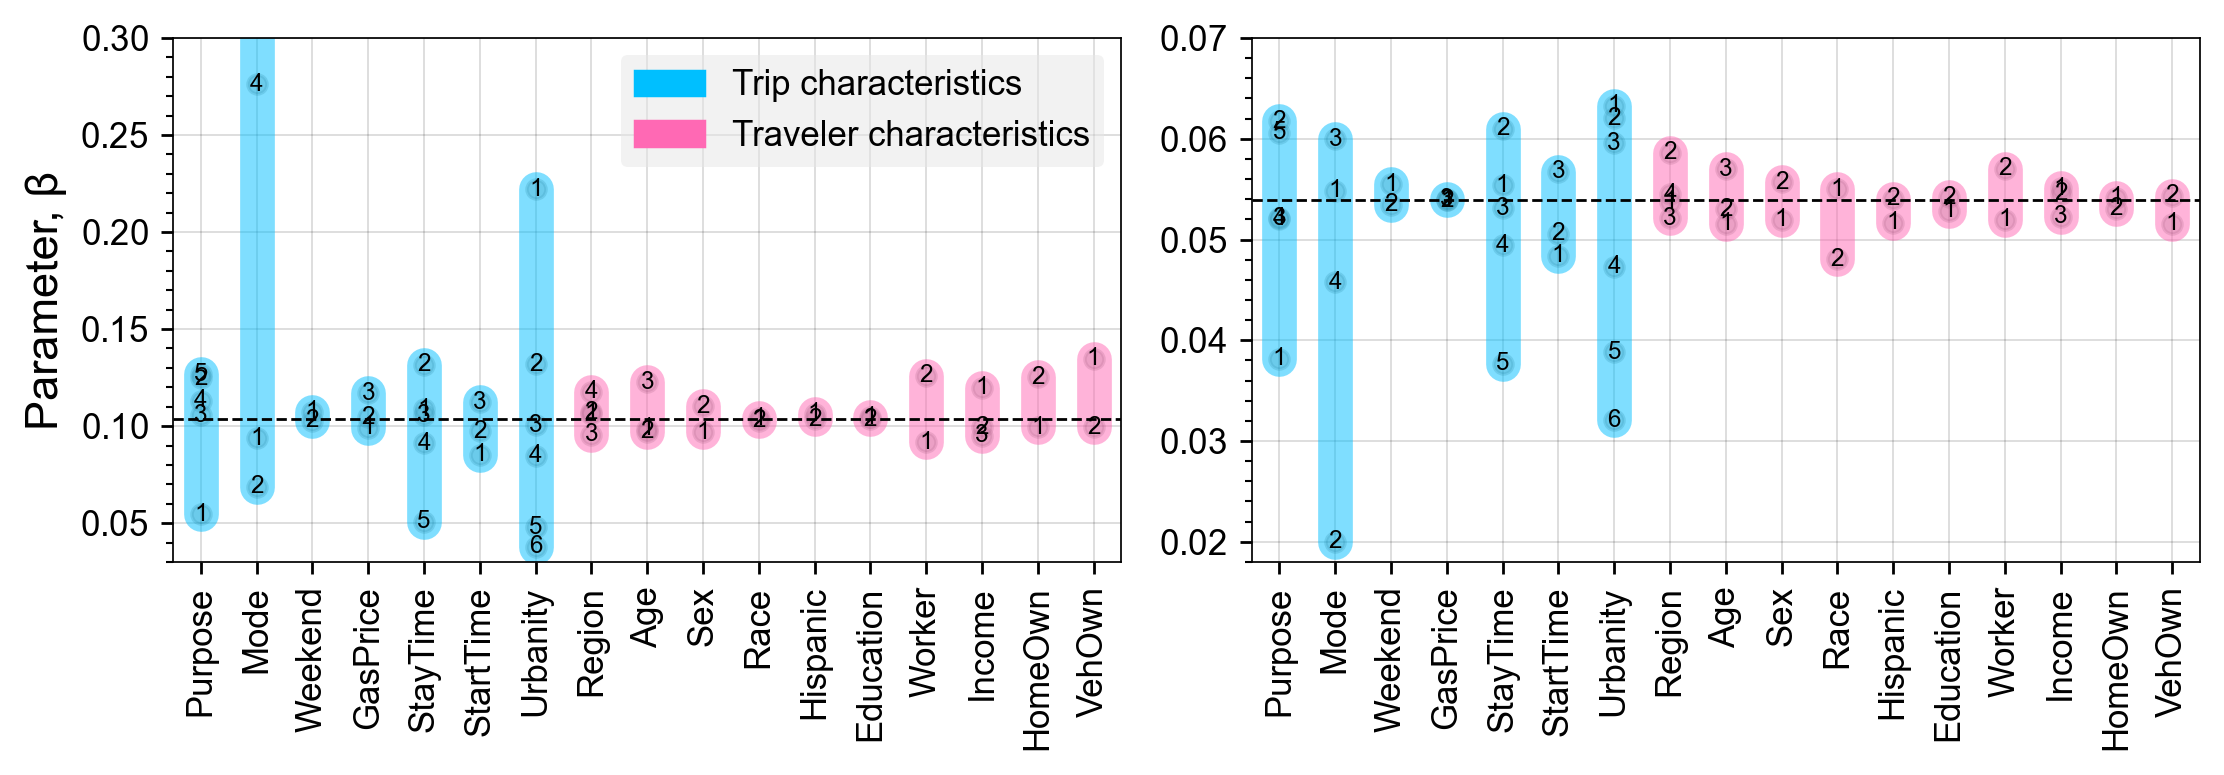

In [14]:
def fig_compare_betas(fitted=fitted, hists=var_hist, grps=col_groups,
                      levels=levels, trips=trips, size=(9, 3.2), dpi=150):
    fit = U.filt(fitted, func='Base exponential').explode('params')
    hists = hists.merge(grps, on='factor')
    fit = fit.merge(grps, on='factor').rename(columns=D(params='beta'))
    fit = fit.merge(levels, on=('factor', 'level'))
    fit.factor = U.factor(fit.factor)
    fit['x'], fit['y'] = fit.factor.cat.codes, -fit.beta
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    betas = []
    for j, target, vmax, ymin, ymax in [
            (0, 'Distance', 80, 0.03, 0.3),
            (1, 'Time', 90, 0.018, 0.07)]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        df = U.filt(hists, target=target)
        df = df.merge(fit[['target', 'factor', 'level', 'beta']])
        df = df.sort_values('beta').reset_index(drop=1)
        betas.append(df)
        ax = U.plot(axes[j], xminor=0, xlim=(-0.5, fit.x.max() + 0.5),
                    ylim=(ymin, ymax), ylab='Parameter, β' if j == 0 else '')
        df1 = U.filt(fit, target=target)
        for (_, color), df in df1.groupby(['factor', 'color']):
            x = df.x.iloc[0]
            ax.scatter(df.x, df.y, s=30, alpha=0.3, color='grey')
            ax.plot([x, x], [df.y.min(), df.y.max()], lw=10,
                color=color, alpha=0.5, solid_capstyle='round')
            for _, r in df.iterrows():
                if r.y > ymax: continue
                ax.text(x, r.y, str(r.level_num), fontsize=7, ha='center', va='center')
        ax.axhline(beta, ls='--', color='k', lw=0.8)
        ax.set_xticks(fit.x.unique(), fit.factor.cat.categories, rotation=90)
        if j == 0:
            ax.legend(fontsize=10, handles=[
                mpl.patches.Patch(label=k + ' characteristics', color=v) for k, v in
                grps.groupby(['group', 'color'], sort=False).size().index])
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    U.imsave('Impedance decay rate parameter comparison by factor')
    return pd.concat(betas)

betas = fig_compare_betas(dpi=250).disp()

## 4.4. Variation by state

In [15]:
# df = (filt(betas, factor='State').assign(Area=lambda df: -1/df.beta)
#       .pivot_table('Area', 'level', 'target').astype(float)
#       .rename_axis('code').reset_index()).disp()

In [16]:
# states = (gpd.read_parquet('../../access/data/zones/us/state_2020.parquet')
#           .merge(pd.read_csv('../../access/data/zones/state_codes.csv'), on='name')
#           .merge(df, on='code')[['name', 'code', 'Distance', 'Time', 'geometry']]
#           .to_crs(CRS_M).assign(num=lambda df: df.index + 1)).disp()

In [17]:
# _, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
# for i, col in enumerate(['Distance', 'Time']):
#     ax = pplot(axes[i], axoff=1, title=col)
#     states.plot(col, ax=ax, ec='grey', lw=0.2, cmap='rainbow', legend=True,
#                 legend_kwds=D(shrink=0.5, label='Area under curve (Trip length)'))
# imsave('Impedance beta by US state')

In [ ]:
# ax = pplot(size=(16, 4), dpi=150, xminor=0)
# sns.barplot(df.groupby, ax=ax, x='level', y='beta', hue='target', palette=['c', 'orange']);